# World of Tanks. Analysis of the players' actions 

## Preface

This is a test task from the Gaming company
All tasks are grouped into 3 sections: 
1. **Data Mining**
2. **Analysis Requirements Formalization**
3. **Analysis Report Preparation.**

These are examples of certain stages of our department's work.

When completing tasks, you can use any information you receive from this document or any other open sources of information about World of Tanks. Also, we do not limit the candidates in terms of the methods and technologies used to solve the tasks assigned to them—use any method that is convenient for you to achieve the result of the task. Good luck!

## Import Libraries and files

In [47]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from IPython.display import Image
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr

# Task 1: Data Collection and Processing

When solving tasks from this section, you can use any implementation of the SQL type (Oracle, Impala/Hive, MySQL, etc.) Be sure to specify which syntax you are using. **I USE FOLLOWING SQL SYNTAX: MySQL (MAKE SURE)**

## Task 1.1: The database contains the player_battles table that contains data about battles played by each player during the day:
where:
- player_id: the unique identifier of a player.
- battle_id: the unique battle identifier that is common for all participants in one battle.
- vehicle_name: the name of the vehicle in which the player entered the battle. Marks like ‘ussr’, ‘uk’, ‘germany’ are identifiers of the vehicle nation.
- dt: battle date.
- exp: the amount of experience received by the player in a battle.

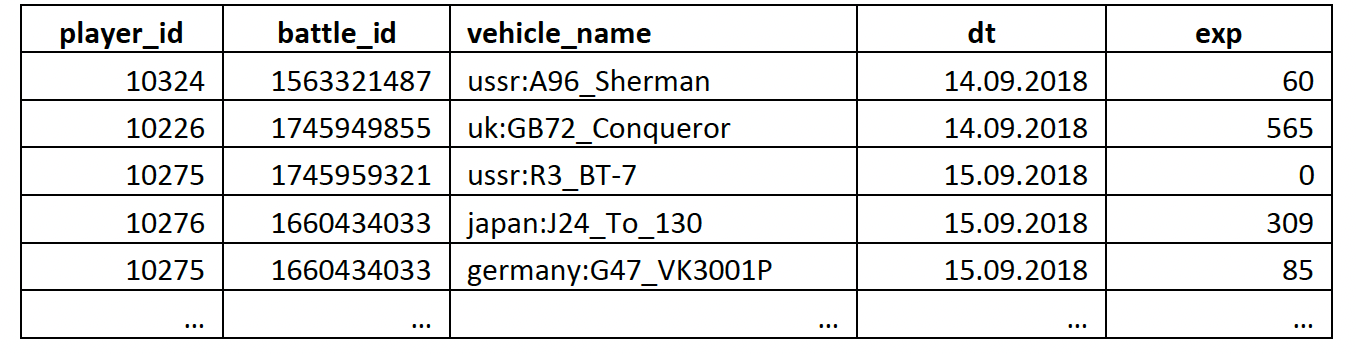

In [2]:
Image(filename='player_battles.png')

### Question 1.1.1: write an SQL-script that allows to display the list of vehicle nations that have fought more than 10,000 battles as of the selected date, for example, 15.09.2018.

Assumptions and Notes:

- Vehicle names are always unique; there are no cases where the same vehicle model exists under different nations (e.g., usa:model_1 and ussr:model_1).
- If a player used the same vehicle model within a day in different battles, it is counted as different intersections.

In [3]:
sql = """
SELECT 
    SUBSTR(vehicle_name, 1, INSTR(vehicle_name, ':') - 1) AS nation,
    COUNT(*) AS cnt
FROM 
    player_battles
WHERE 
    dt = '2018-08-15'
GROUP BY 
    SUBSTR(vehicle_name, 1, INSTR(vehicle_name, ':') - 1)
HAVING 
    COUNT(*) > 10000;
"""

### Question 1.1.2: **Get Information on Unique Players by Battle Cohorts:**
   Write an SQL script to retrieve information about the number of unique players who fought a certain number of battles, categorized by cohorts:
   - [0;10] battles
   - [10;20] battles
   - [20;50] battles
   - [50;100] battles
   - [100;+inf] battles

Assumptions and Notes:

- in pointed ranges there are intersections with corner values e.g 0-10 for the 1st cohort and 10-11 for the second, and it is not obvious at what cohort we should put number = 10, that's why all the cohorts xcept 1st will start from start_value + 1 (e.g. for range [10:20] contains values from 11 to 20)

In [4]:
# Define the SQL query
query = '''
WITH battle_counts AS (
    SELECT player_id, COUNT(*) AS num_battles
    FROM player_battles
    GROUP BY player_id
),
cohorts AS (
    SELECT 
        player_id,
        CASE 
            WHEN num_battles BETWEEN 0 AND 10 THEN '[0;10] battles'
            WHEN num_battles BETWEEN 11 AND 20 THEN '[10;20] battles'
            WHEN num_battles BETWEEN 21 AND 50 THEN '[20;50] battles'
            WHEN num_battles BETWEEN 51 AND 100 THEN '[50;100] battles'
            ELSE '[100;+inf] battles'
        END AS cohort
    FROM battle_counts
)
SELECT 
    cohort,
    COUNT(DISTINCT player_id) AS unique_player_count
FROM cohorts
GROUP BY cohort
ORDER BY 
    CASE 
        WHEN cohort = '[0;10] battles' THEN 1
        WHEN cohort = '[10;20] battles' THEN 2
        WHEN cohort = '[20;50] battles' THEN 3
        WHEN cohort = '[50;100] battles' THEN 4
        ELSE 5
    END;
'''

### Question 1.1.3: **Count Players Active on Both Days:** Write an SQL script to count the number of players who were active on both 14.09.2018 and 15.09.2018.


In [5]:
query = '''
SELECT COUNT(*) AS active_on_both_dates
FROM (
    SELECT COUNT(DISTINCT player_id) AS active_on_both_dates
    FROM player_battles
    WHERE dt IN ('2018-09-14', '2018-09-15')
    GROUP BY player_id
    HAVING COUNT(DISTINCT dt) = 2
) AS subquery;
'''

## Task 1.2: You have two tables (see below) which one of them contains battle statistics per player and the second one contains a list of unique identifiers of players who are developers (dev_player_id):
where:
- battle_id : the unique battle identifier which is common for all participants in one battle;
- battle_start : the exact time when a battle started;
- player_id : the unique identifier of a player;
- team_id : the identifier of a team in which a player was distributed in a battle. There are two teams in a battle;
- tank_id : the unique identifier of a vehicle in which the player entered the battle;
- damage : the amount of damage done to the enemies by the player in a battle;
- credits : the number of credits received by the player in a battle;
- exp : the amount of experience received by the player in a battle;
- team_won_id : the unique identifier of the team who won a battle.

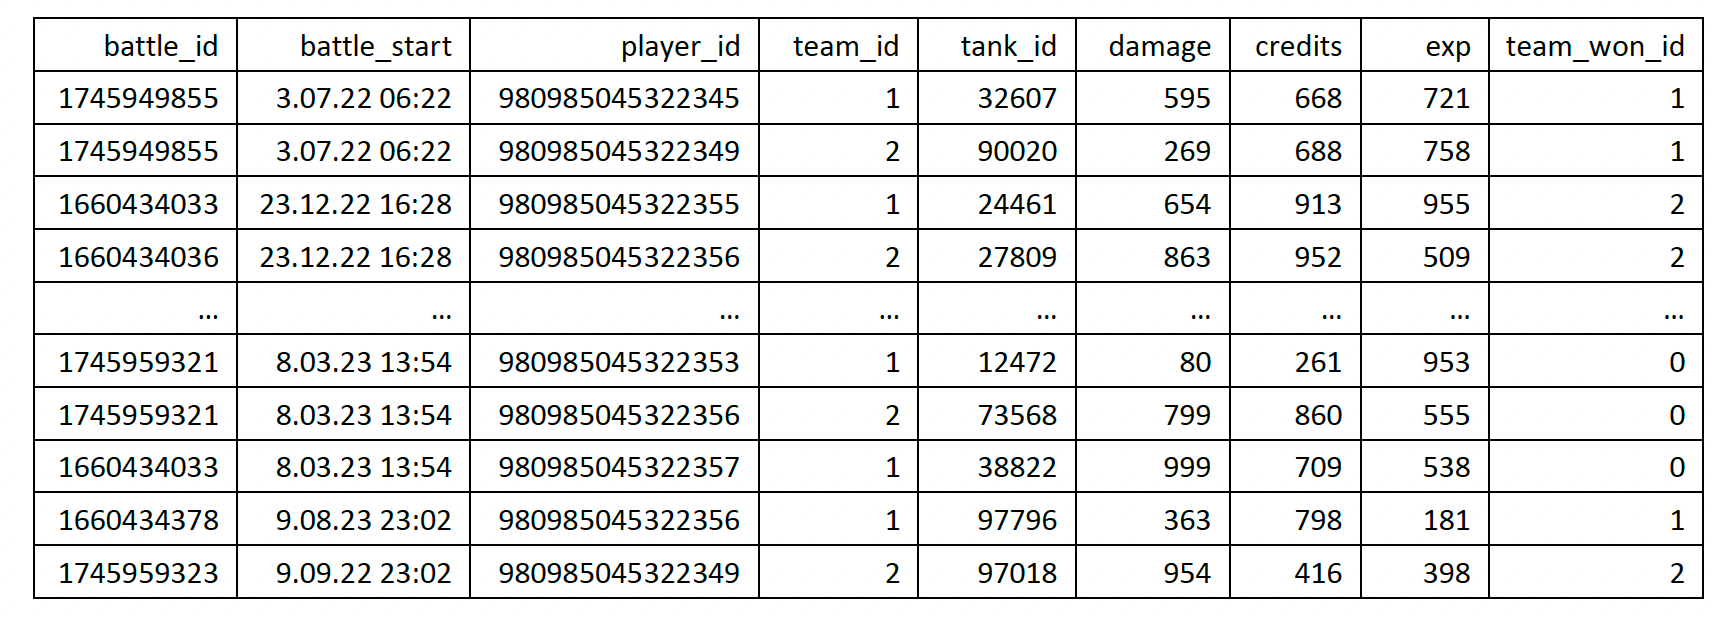

In [6]:
Image(filename='battles_stat.png')

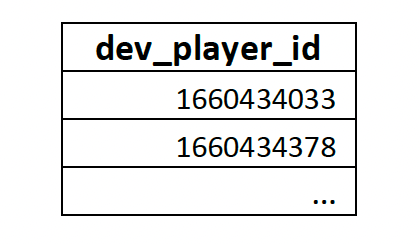

In [7]:
Image(filename='dev_players.png')

### Question 1.2.1: Using the tables above, please write an SQL script to gather following metrics for each player the following: 
- the amount of damage done to the enemies and earned credits in the last player’s won battle excluding developers;
- date and time of the first lost player’s battle excluding developers;

In [8]:
query = '''
-- CTE to get the last battle won by each player, excluding developers
WITH last_won_battles AS (
    SELECT
        b.player_id,
        MAX(b.battle_start) AS last_won_battle_start
    FROM
        battle_statistics b
    WHERE
        b.team_id = b.team_won_id -- Player's team won
        AND b.player_id NOT IN (SELECT dev_player_id FROM developer_players) -- Exclude developers
    GROUP BY
        b.player_id
),

-- CTE to get the damage and credits for the last won battle for each player
last_won_battle_details AS (
    SELECT
        b.player_id,
        b.damage,
        b.credits
    FROM
        battle_statistics b
    JOIN
        last_won_battles l
    ON
        b.player_id = l.player_id
        AND b.battle_start = l.last_won_battle_start
    WHERE
        b.player_id NOT IN (SELECT dev_player_id FROM developer_players) -- Exclude developers
),

-- CTE to get the first lost battle for each player, excluding developers
first_lost_battles AS (
    SELECT
        b.player_id,
        MIN(b.battle_start) AS first_lost_battle_start
    FROM
        battle_statistics b
    WHERE
        b.team_id != b.team_won_id -- Player's team lost
        AND b.player_id NOT IN (SELECT dev_player_id FROM developer_players) -- Exclude developers
    GROUP BY
        b.player_id
)

-- Final query to select the required metrics
SELECT
    l.player_id,
    COALESCE(SUM(l.damage), 0) AS total_damage_last_won_battle,
    COALESCE(SUM(l.credits), 0) AS total_credits_last_won_battle,
    f.first_lost_battle_start
FROM
    last_won_battle_details l
LEFT JOIN
    first_lost_battles f
ON
    l.player_id = f.player_id
GROUP BY
    l.player_id, f.first_lost_battle_start
ORDER BY
    l.player_id;
'''

# Task 2: Analysis Requirements Formalization

In World of Tanks there are launched the seasons of Battle pass with the duration around 3 months each (Battle pass description in the WoT Portal).

The Producer came to you as a Data Analyst and requested to provide the responsible team with monitoring of the Battle pass health metrics to understand the current state of activity and, if necessary, make prompt decisions in the World of Tanks project. Please, complete the following:

- Formulate 10 questions that you would ask the Producer to better understand the in-game activity that is being launched.
- Suggest at least 10 metrics that you would suggest to the Producer to monitor the event status.
- Suggest ways and tools to complete the received request.
- Additionally (optional): Describe the stages/sequence of your actions to complete the request.

## 2.1. Formulate 10 questions that you would ask the Producer to better understand the in-game activity that is being launched.

1. **Success Definition:** How do you define a successful Battle Pass season in terms of player engagement and monetization? What are the specific targets or benchmarks for success?

2. **Player Behavior Concerns:** Are there any specific player behavior patterns or issues related to the Battle Pass that you are currently concerned about?

3. **User Segmentation:** Are there particular user segments or demographics you are interested in tracking? Segmenting data by these groups can help us understand how different player types interact with the Battle Pass.

4. **Promotional Activities:** Are there any planned promotional activities or special events associated with the Battle Pass? How should these be factored into our analysis of player engagement?

5. **Player Feedback and Issues:** Are there any known issues or specific feedback from players regarding the current Battle Pass? How should we address these in our analysis?

6. **Engagement Metrics:** What specific metrics should we use to measure player engagement with the Battle Pass? Should we focus on metrics like participation rates, progression rates, or other indicators?

7. **Drop-off Analysis:** What are the typical drop-off points in player engagement or progression within the Battle Pass? How should we monitor these drop-offs and what strategies can be employed to mitigate them?

8. **Feedback Collection:** How should we collect and analyze player feedback and satisfaction related to the Battle Pass? Are there specific feedback channels, surveys, or methods that you prefer?

9. **Competitive Benchmarking:** Should we benchmark our Battle Pass metrics against similar features in competing games? If so, what aspects should we compare, and how will this comparison inform our strategy?

10. **Anticipated Challenges:** Are there any anticipated challenges or issues for this Battle Pass season that we should be aware of, such as technical problems or balancing issues? How should we prepare for these?

## 2.2. Suggest at least 10 metrics that you would suggest to the Producer to monitor the event status.


1. **Participation Rate**  
   Percentage of active players engaging with the Battle Pass. Indicates initial interest and adoption.

2. **Progression Rate**  
   Average level or tier reached by players over time. Shows how effectively players are advancing through tiers.

3. **Completion Rate**  
   Percentage of players who complete the Battle Pass by reaching the highest tier. Measures overall success and appeal.

4. **Revenue per Player**  
   Average revenue generated per player from Battle Pass purchases. Assesses monetization effectiveness.

5. **Improvement Rate**  
   Percentage of players upgrading Battle Pass. Measures success in upgrading Battle Pass.

6. **Active vs. Passive Engagement**  
   Comparison between players actively engaging with Battle Pass tasks versus those who only complete minimal tasks. Differentiates between deeply involved players and those with minimal engagement.

7. **Player Feedback and Satisfaction Scores**  
   Ratings or feedback from players about their Battle Pass experience. Provides insights into player satisfaction and areas for improvement.

8. **Task Completion Rates**  
   Percentage of tasks or missions within the Battle Pass that players complete. Indicates how engaging and achievable tasks are.

9. **Daily/Weekly Activity Trends**  
   Patterns in player activity related to the Battle Pass on a daily or weekly basis. Helps identify peak engagement times and overall behavior.

10. **In-Game Economy Impact**  
    Effect of the Battle Pass on in-game wins and losses

## 2.3. Suggest ways and tools to complete the received request.

1. **Data Collection:** Use logging systems to capture player interactions and transactions related to the Battle Pass.

2. **Data Analysis:** Employ SQL databases or data warehouses to store and query data. Use Python with libraries like Pandas for data manipulation and analysis. Utilize data visualization tools like Tableau or Power BI to create dashboards and reports.

3. **Player Segmentation:** Analyze player demographics and behavior using clustering techniques to understand different segments.

4. **Feedback Analysis:** Use sentiment analysis tools to analyze player feedback from forums, social media, and surveys.

5. **A/B Testing:** Implement A/B testing to evaluate the impact of different Battle Pass features or promotional activities.

6. **Monitoring Tools:** Set up real-time dashboards for monitoring key metrics and trends using tools like Grafana or Kibana.

7. **Reporting:** Generate periodic reports to track progress and make data-driven recommendations.

## 2.4. Additionally (optional): Describe the stages/sequence of your actions to complete the request.

1. **Define Objectives:** Clarify the goals of the Battle Pass event with the Producer and determine the key metrics needed to assess its success.

2. **Data Collection Setup:** Ensure that data collection mechanisms are in place to capture relevant player activity and transaction data.

3. **Data Integration:** Integrate data from various sources (e.g., game logs, transactional data) into a central database or data warehouse.

4. **Data Cleaning and Preparation:** Clean and prepare data for analysis, ensuring accuracy and completeness.

5. **Metric Calculation:** Calculate the defined metrics and analyze trends and patterns.

6. **Visualization and Reporting:** Create visualizations and reports to communicate findings to the Producer and other stakeholders.

7. **Feedback and Iteration:** Gather feedback on the analysis and iterate on the metrics and methods as needed.

8. **Monitor and Optimize:** Continuously monitor the metrics throughout the Battle Pass season and make recommendations for adjustments based on real-time data.

# Task 3: Analysis Report Preparation

## Task 3.1
The attached data_1.csv file contains battles data for two groups of players divided by availability of some changes in setting and configuration in the game. 
- For group A changes were available
- for group B were not. 
- Data includes activity from 2022-10-01 till 2022-11-29. 
- From 2022-10-27 to 2022-11-29 changes were available for Group A.

**Please, show the approaches in data analysis and visualization known to you. Feel free use any tools, technics, and approaches to complete the task:**
- Examine the data set and carry out the analysis. We expect some report on your research that would show the performance of released changes in the game and other interesting facts that you’re able to find in the data set. It’s supposed to be the report for business stakeholders who make decision about launched improvements.
- Based on the results of the generated report, briefly describe the observations and conclusions that you made when processing and analyzing the data.
- Optional: Based on the results, provide the Product Manager with recommendations on how to improve the performance of updates and new vehicle branches in the future.

**Analysis Steps:**
1. EDA
2. Answer Questions
3. Visualisation
4. Outcomes
5. Recomendations

### Task 3.1.1. EDA


In [9]:
battles_df = pd.read_csv('data_1.csv')
battles_df.head()

,player_id,battle_id,dt,player_group,in_battle_presence_time,damage_dealt,kills_made,vehicle_lvl,account_created_at
0,4acaed46f5c1f955031286b7115e6c494c047f705e7441...,dfcc03237ac70b54f1fe71b99be75ab46286f8d091536c...,27.11.22,B,832,0,0,8,16.11.22
1,c5a9edef16454d022d32adbd010c7773c7a5ca53717a06...,cfbee8667ffa06cf9cc808544e7137cacb0367a9fc4408...,20.10.22,B,142,423,0,8,28.11.15
2,4cc362ca0eac5fae41b6c56bb858803953d802b58af6fd...,01592abfe1b16666bb349dcf1f90bb0ecfd685d82a9c10...,25.11.22,A,208,1540,1,6,31.10.15
3,1a32f95ecb3174915c63c4be509e29a5bb37d16ecd2345...,0a705163ce3646518c91a50a722eea507f45c7827bd1ae...,13.10.22,B,707,2582,1,8,13.10.22
4,03f5e518c2a127c52eb7b2dc9ce28ad677f9d5e3d88053...,7970e8ba29ddbd6eaa2c982f61a0046dfb88e7ea97c00b...,18.10.22,A,283,133,0,7,29.04.14


In [10]:
battles_df.shape

(374217, 9)

In [11]:
battles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374217 entries, 0 to 374216
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   player_id                374217 non-null  object
 1   battle_id                374217 non-null  object
 2   dt                       374217 non-null  object
 3   player_group             374217 non-null  object
 4   in_battle_presence_time  374217 non-null  int64 
 5   damage_dealt             374217 non-null  int64 
 6   kills_made               374217 non-null  int64 
 7   vehicle_lvl              374217 non-null  int64 
 8   account_created_at       374217 non-null  object
dtypes: int64(4), object(5)
memory usage: 25.7+ MB


In [12]:
# unique players
battles_df['player_id'].nunique()

2857

In [13]:
# unique battles
battles_df['battle_id'].nunique()

362665

In [48]:
# change data type
battles_df['dt'] = pd.to_datetime(battles_df['dt'])
battles_df['account_created_at'] = pd.to_datetime(battles_df['account_created_at'])

In [15]:
# check min & max dates
battles_df['dt'].min(), battles_df['dt'].max()

(Timestamp('2022-01-11 00:00:00'), Timestamp('2022-12-11 00:00:00'))

In [16]:
# check min & max dates
battles_df['account_created_at'].min(), battles_df['account_created_at'].max()

(Timestamp('2011-01-05 00:00:00'), Timestamp('2022-12-11 00:00:00'))

In [17]:
# check levels
vehicle_lvl_counts = battles_df['vehicle_lvl'].value_counts().sort_index()
vehicle_lvl_counts

vehicle_lvl
1       2793
2       5702
3      13385
4      21663
5      34288
6      52593
7      43030
8     103956
9      52609
10     44198
Name: count, dtype: int64

**EDA outcomes 1st**:
- upload data
- changed data types
- add new columns
- observed distribution

### Task 3.1.2. QUESTIONS TO ANALYZE
- how vehicle_lvl affects key metrics, hypothesis: as vehicle_lvl increases, user metrics increase.
- Is there a dependency of vehicle_lvl on account_created_at, hypothesis: as duration increases so does levl. And how long does it take to get to a certain level?
- Is the first game of the day really not the most successful? Should we take each player's first games and compare the metrics with the rest of the games?
- Are the metrics for game duration different during the week? The main hypothesis is that players are more active on weekends.

In [18]:
battles_df.head()

,player_id,battle_id,dt,player_group,in_battle_presence_time,damage_dealt,kills_made,vehicle_lvl,account_created_at
0,4acaed46f5c1f955031286b7115e6c494c047f705e7441...,dfcc03237ac70b54f1fe71b99be75ab46286f8d091536c...,2022-11-27,B,832,0,0,8,2022-11-16
1,c5a9edef16454d022d32adbd010c7773c7a5ca53717a06...,cfbee8667ffa06cf9cc808544e7137cacb0367a9fc4408...,2022-10-20,B,142,423,0,8,2015-11-28
2,4cc362ca0eac5fae41b6c56bb858803953d802b58af6fd...,01592abfe1b16666bb349dcf1f90bb0ecfd685d82a9c10...,2022-11-25,A,208,1540,1,6,2015-10-31
3,1a32f95ecb3174915c63c4be509e29a5bb37d16ecd2345...,0a705163ce3646518c91a50a722eea507f45c7827bd1ae...,2022-10-13,B,707,2582,1,8,2022-10-13
4,03f5e518c2a127c52eb7b2dc9ce28ad677f9d5e3d88053...,7970e8ba29ddbd6eaa2c982f61a0046dfb88e7ea97c00b...,2022-10-18,A,283,133,0,7,2014-04-29


**how vehicle_lvl affects key metrics, hypothesis: as vehicle_lvl increases, user metrics increase.**

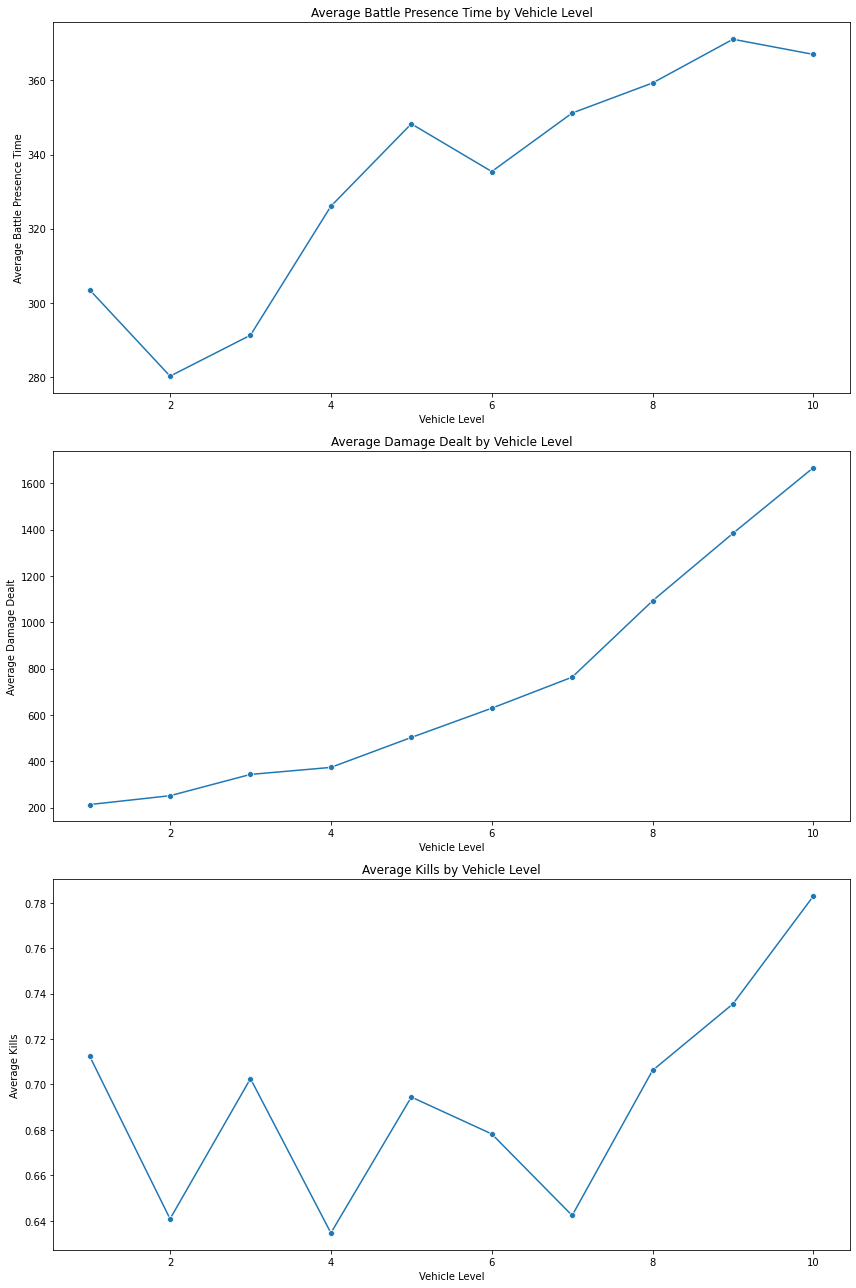

{'in_battle_presence_time': PearsonRResult(statistic=0.9185149275463723, pvalue=0.00017465392126517838),
 'damage_dealt': PearsonRResult(statistic=0.9514486004838844, pvalue=2.2922117943333192e-05),
 'kills_made': PearsonRResult(statistic=0.5216097589498151, pvalue=0.12202803620755948)}

In [19]:
grouped_df = battles_df.groupby('vehicle_lvl').agg({
    'in_battle_presence_time': 'mean',
    'damage_dealt': 'mean',
    'kills_made': 'mean'
}).reset_index()

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

sns.lineplot(ax=axes[0], data=grouped_df, x='vehicle_lvl', y='in_battle_presence_time', marker='o')
axes[0].set_title('Average Battle Presence Time by Vehicle Level')
axes[0].set_xlabel('Vehicle Level')
axes[0].set_ylabel('Average Battle Presence Time')

sns.lineplot(ax=axes[1], data=grouped_df, x='vehicle_lvl', y='damage_dealt', marker='o')
axes[1].set_title('Average Damage Dealt by Vehicle Level')
axes[1].set_xlabel('Vehicle Level')
axes[1].set_ylabel('Average Damage Dealt')

sns.lineplot(ax=axes[2], data=grouped_df, x='vehicle_lvl', y='kills_made', marker='o')
axes[2].set_title('Average Kills by Vehicle Level')
axes[2].set_xlabel('Vehicle Level')
axes[2].set_ylabel('Average Kills')

plt.tight_layout()
plt.show()

# Statistical analysis
# Correlation between vehicle level and metrics
correlation_in_battle_presence_time = pearsonr(grouped_df['vehicle_lvl'], grouped_df['in_battle_presence_time'])
correlation_damage_dealt = pearsonr(grouped_df['vehicle_lvl'], grouped_df['damage_dealt'])
correlation_kills_made = pearsonr(grouped_df['vehicle_lvl'], grouped_df['kills_made'])

correlation_results = {
    'in_battle_presence_time': correlation_in_battle_presence_time,
    'damage_dealt': correlation_damage_dealt,
    'kills_made': correlation_kills_made
}

correlation_results

**Is there a dependency of vehicle_lvl on account_created_at, hypothesis: as duration increases so does levl. And how long does it take to get to a certain level?**

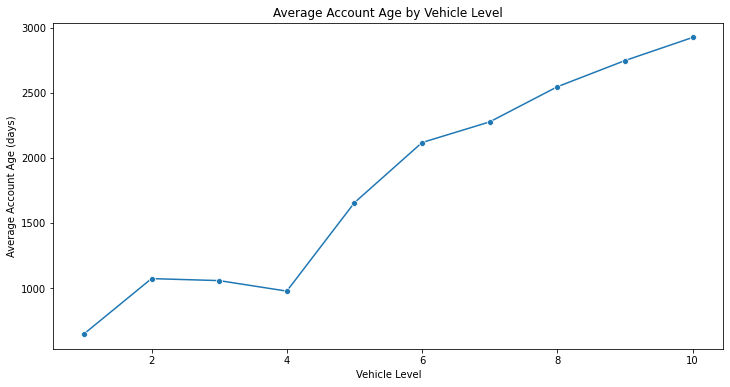

PearsonRResult(statistic=0.9768372467084228, pvalue=1.2246610855326957e-06)

In [20]:
# Calculate the age of the account at the time of each battle
battles_df['account_age_days'] = (battles_df['dt'] - battles_df['account_created_at']).dt.days

# Group data by vehicle level and calculate the average account age
grouped_age_battles_df = battles_df.groupby('vehicle_lvl').agg({
    'account_age_days': 'mean'
}).reset_index()

# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_age_battles_df, x='vehicle_lvl', y='account_age_days', marker='o')
plt.title('Average Account Age by Vehicle Level')
plt.xlabel('Vehicle Level')
plt.ylabel('Average Account Age (days)')
plt.show()

# Statistical analysis
# Calculate the correlation between vehicle level and account age
correlation_age_vehicle_lvl = pearsonr(grouped_age_battles_df['vehicle_lvl'], grouped_age_battles_df['account_age_days'])

correlation_age_vehicle_lvl

**Is the first game of the day really not the most successful? Should we take each player's first games and compare the metrics with the rest of the games?**

In [21]:
# Sort data by player_id and game time
battles_df = battles_df.sort_values(by=['player_id', 'dt'])

# Determine the first game of the day for each player
# Create a column to mark the first game for each day and player
battles_df['is_first_game'] = battles_df.groupby(['player_id', 'dt']).cumcount() == 0

# Split data into first games and other games
first_games = battles_df[battles_df['is_first_game']]
other_games = battles_df[~battles_df['is_first_game']]

# Optional: Print the number of games in each category to verify
print(f"Number of first games: {len(first_games)}")
print(f"Number of other games: {len(other_games)}")

Number of first games: 29364
Number of other games: 344853


In [22]:
# Define the metrics for analysis
metrics = ['in_battle_presence_time', 'damage_dealt', 'kills_made']

# Calculate the mean values of metrics for the first games
first_games_means = first_games[metrics].mean()

# Calculate the mean values of metrics for the other games
other_games_means = other_games[metrics].mean()

# Combine the results for comparison
comparison_df = pd.DataFrame({
    'First Games': first_games_means,
    'Other Games': other_games_means
})

# Display the comparison DataFrame
comparison_df


,First Games,Other Games
in_battle_presence_time,353.829349,350.332916
damage_dealt,918.893850,959.878789
kills_made,0.686589,0.703114


In [23]:
# Define the metrics for analysis
metrics = ['in_battle_presence_time', 'damage_dealt', 'kills_made']

# Initialize a dictionary to store t-test results
ttest_results = {}

# Perform t-test for each metric
for metric in metrics:
    # Perform t-test between first games and other games for the current metric
    ttest_results[metric] = ttest_ind(first_games[metric], other_games[metric])

# Display the t-test results
ttest_results

{'in_battle_presence_time': TtestResult(statistic=3.5828057754704785, pvalue=0.00033996646687730833, df=374215.0),
 'damage_dealt': TtestResult(statistic=-7.302185188809254, pvalue=2.836895003020644e-13, df=374215.0),
 'kills_made': TtestResult(statistic=-2.6549056420209993, pvalue=0.007933395250865033, df=374215.0)}

**Are the metrics for game duration different during the week? The main hypothesis is that players are more active on weekends**

In [24]:
battles_df['day_of_week'] = battles_df['dt'].dt.dayofweek
battles_df.head()

,player_id,battle_id,dt,player_group,in_battle_presence_time,damage_dealt,kills_made,vehicle_lvl,account_created_at,account_age_days,is_first_game,day_of_week
121420,0051ec022d654c63a17a45737006ced0cf7d7cec063d40...,b433888aaec2f707bf7101411786dd09a404bdbd07f6a9...,2022-07-11,B,442,1761,1,7,2020-05-22,780,True,0
158236,0051ec022d654c63a17a45737006ced0cf7d7cec063d40...,99766ee20e9a133e563a95eaaf25fb6dc5b408218254cb...,2022-07-11,B,217,641,0,7,2020-05-22,780,False,0
223630,0051ec022d654c63a17a45737006ced0cf7d7cec063d40...,ee4018955f8ea6f044775dd6b21f00499cb930d53feddf...,2022-07-11,B,538,354,1,6,2020-05-22,780,False,0
254138,0051ec022d654c63a17a45737006ced0cf7d7cec063d40...,9e2e396548237fefbd603ebbab48a136a7b1a71595eaa5...,2022-07-11,B,330,144,1,5,2020-05-22,780,False,0
324876,0051ec022d654c63a17a45737006ced0cf7d7cec063d40...,9ba5adb81d3a1cf40b4576b6fa74d875dd64cd057571fd...,2022-07-11,B,244,780,0,7,2020-05-22,780,False,0


In [25]:
# Group data by day of the week and calculate the average 'in_battle_presence_time'
mean_in_battle_presence_time_per_day = battles_df.groupby('day_of_week')['in_battle_presence_time'].mean().reset_index()

# Add day names for better readability
mean_in_battle_presence_time_per_day['day_name'] = mean_in_battle_presence_time_per_day['day_of_week'].apply(
    lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][x]
)

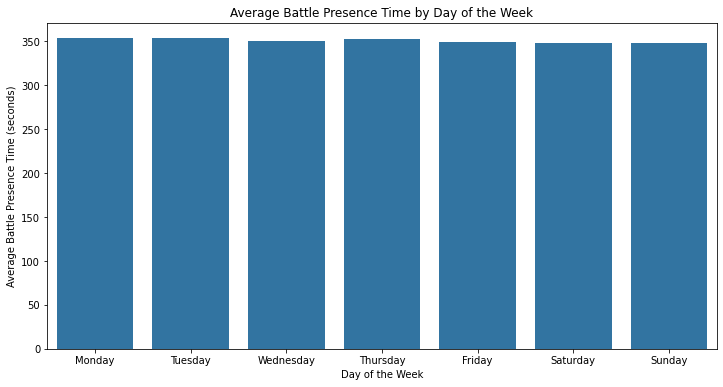

In [26]:
# Plotting the average in_battle_presence_time by day of the week
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_in_battle_presence_time_per_day, x='day_name', y='in_battle_presence_time', 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average Battle Presence Time by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Battle Presence Time (seconds)')
plt.show()

### Task 3.1.2. QUESTIONS TO ANALYZE OUTCOMES:
**Correlation with Vehicle Level:**

1. in_battle_presence_time and damage_dealt: The strong correlations (both over 0.9) indicate a significant relationship between vehicle_lvl and these metrics. As the vehicle level increases, players tend to have higher in_battle_presence_time and damage_dealt. This suggests that higher-level vehicles are associated with more time spent in battle and more damage dealt, which could be due to better performance or improved capabilities of higher-level vehicles.

2. kills_made: A correlation of 0.52 is moderate, suggesting a weaker but still present relationship between vehicle_lvl and kills_made. This indicates that while higher vehicle levels might contribute to a higher number of kills, the relationship is not as strong or straightforward as with the other two metrics.

**Correlation Between Vehicle Level and Account Age:**

1. There is a strong correlation between vehicle_lvl and account_age_days, players with older accounts are more likely to have progressed to higher vehicle levels, potentially due to longer gameplay time or increased experience.

2. First Games vs. Subsequent Games:First Player's Games: If players' first games are typically worse than subsequent ones, it suggests a learning curve or adaptation period. Players may need some time to become familiar with the game mechanics, improve their strategies, or become more proficient with their vehicles. This could be due to less familiarity with game dynamics or less experience in the early stages of gameplay.

**Day of the Week Analysis:**

1. No Significant Difference: The analysis shows that there is no significant difference in metrics like in_battle_presence_time or others based on the day of the week. This implies that player behavior in terms of game activity is consistent throughout the week, and there is no discernible pattern related to day-specific variations in gameplay metrics.

### Task 3.1.3. Analysis of the implemented feature:
- what metrics to take for analysis: in_battle_presence_time, damage_dealt, kills_made
- are the mean values of metrics in group A before the change and in group B before the change different?
- Are the mean values of metrics in group A after the change and the same period of group B different?

In [27]:
battles_df.head()

,player_id,battle_id,dt,player_group,in_battle_presence_time,damage_dealt,kills_made,vehicle_lvl,account_created_at,account_age_days,is_first_game,day_of_week
121420,0051ec022d654c63a17a45737006ced0cf7d7cec063d40...,b433888aaec2f707bf7101411786dd09a404bdbd07f6a9...,2022-07-11,B,442,1761,1,7,2020-05-22,780,True,0
158236,0051ec022d654c63a17a45737006ced0cf7d7cec063d40...,99766ee20e9a133e563a95eaaf25fb6dc5b408218254cb...,2022-07-11,B,217,641,0,7,2020-05-22,780,False,0
223630,0051ec022d654c63a17a45737006ced0cf7d7cec063d40...,ee4018955f8ea6f044775dd6b21f00499cb930d53feddf...,2022-07-11,B,538,354,1,6,2020-05-22,780,False,0
254138,0051ec022d654c63a17a45737006ced0cf7d7cec063d40...,9e2e396548237fefbd603ebbab48a136a7b1a71595eaa5...,2022-07-11,B,330,144,1,5,2020-05-22,780,False,0
324876,0051ec022d654c63a17a45737006ced0cf7d7cec063d40...,9ba5adb81d3a1cf40b4576b6fa74d875dd64cd057571fd...,2022-07-11,B,244,780,0,7,2020-05-22,780,False,0


In [28]:
# Define periods
pre_change_start = '2022-10-01'
pre_change_end = '2022-10-26'
change_start = '2022-10-27'
change_end = '2022-11-29'

# Filter Group A before change
group_A_before_change = battles_df[(battles_df['player_group'] == 'A') & (battles_df['dt'] >= pre_change_start) & (battles_df['dt'] <= pre_change_end)]

# Filter Group A after change
group_A_change_period = battles_df[(battles_df['player_group'] == 'A') & (battles_df['dt'] >= change_start) & (battles_df['dt'] <= change_end)]

# Filter Group B same period as before change in Group A
group_B_same_period = battles_df[(battles_df['player_group'] == 'B') & (battles_df['dt'] >= pre_change_start) & (battles_df['dt'] <= pre_change_end)]

# Filter Group B same period as after change in Group A
group_B_change_period = battles_df[(battles_df['player_group'] == 'B') & (battles_df['dt'] >= change_start) & (battles_df['dt'] <= change_end)]


In [29]:
def plot_histograms_comparison(df1, df2, period1, period2, metrics, ax):
    """
    Plot histograms to compare two periods for given metrics.

    :param df1: DataFrame for the first period
    :param df2: DataFrame for the second period
    :param period1: Name of the first period
    :param period2: Name of the second period
    :param metrics: List of metrics to compare
    :param ax: Array of axes for plotting
    """
    # Colors for different periods and statistics
    colors = {
        'period1_hist': 'steelblue',
        'period2_hist': 'salmon',
        'period1_mean': 'darkblue',
        'period2_mean': 'darkred'
    }
    
    for i, metric in enumerate(metrics):
        # Calculate mean values for both periods
        mean1 = df1[metric].mean()
        mean2 = df2[metric].mean()
        
        # Calculate subplot index
        row = i // 2
        col = i % 2
        
        # Plot histograms for the metric
        ax[row, col].hist(df1[metric], bins=10, alpha=0.5, label=f'{period1} Mean: {mean1:.2f}', color=colors['period1_hist'])
        ax[row, col].hist(df2[metric], bins=10, alpha=0.5, label=f'{period2} Mean: {mean2:.2f}', color=colors['period2_hist'])
        
        # Plot vertical lines for mean values
        ax[row, col].axvline(mean1, color=colors['period1_mean'], linestyle='dashed', linewidth=1, label=f'{period1} Mean')
        ax[row, col].axvline(mean2, color=colors['period2_mean'], linestyle='dashed', linewidth=1, alpha=0.5, label=f'{period2} Mean')
        
        # Set plot title and labels
        ax[row, col].set_title(f'{metric.replace("_", " ").title()}')
        ax[row, col].set_xlabel(metric.replace("_", " ").title())
        ax[row, col].set_ylabel('Frequency')
        ax[row, col].legend()


**comparasion between group A & B: before change**

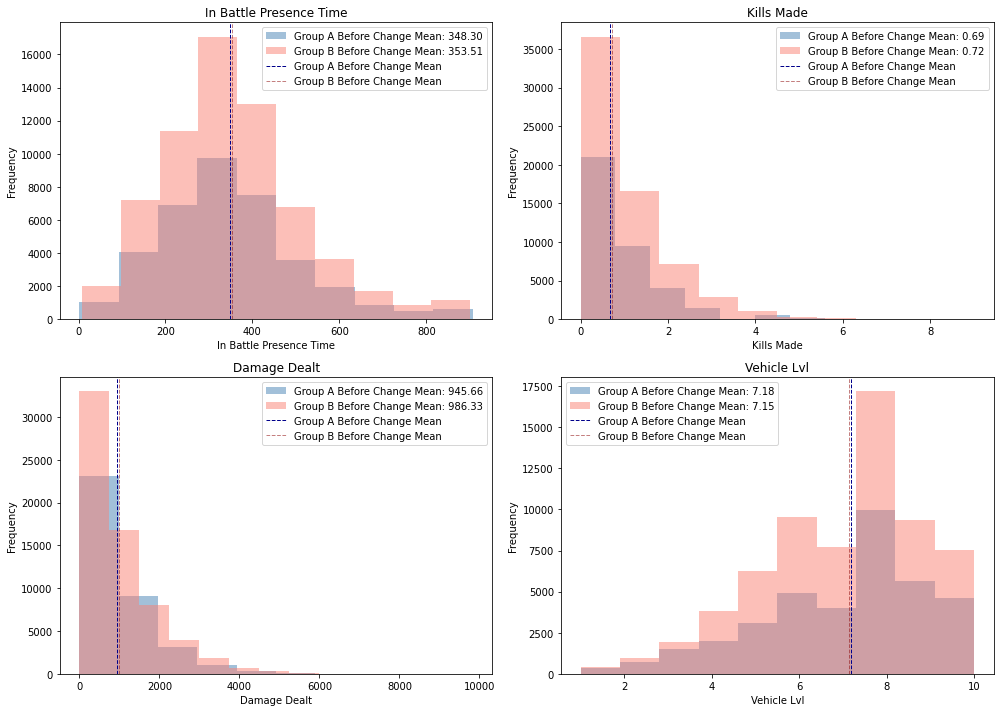

In [30]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# List of metrics to compare
metrics = ['in_battle_presence_time', 'kills_made', 'damage_dealt', 'vehicle_lvl']

# Plot histograms to compare two periods
plot_histograms_comparison(
    group_A_before_change, 
    group_B_same_period, 
    'Group A Before Change', 
    'Group B Before Change', 
    metrics, 
    axes
)

plt.tight_layout()
plt.show()

**comparasion between group A & B: after change**

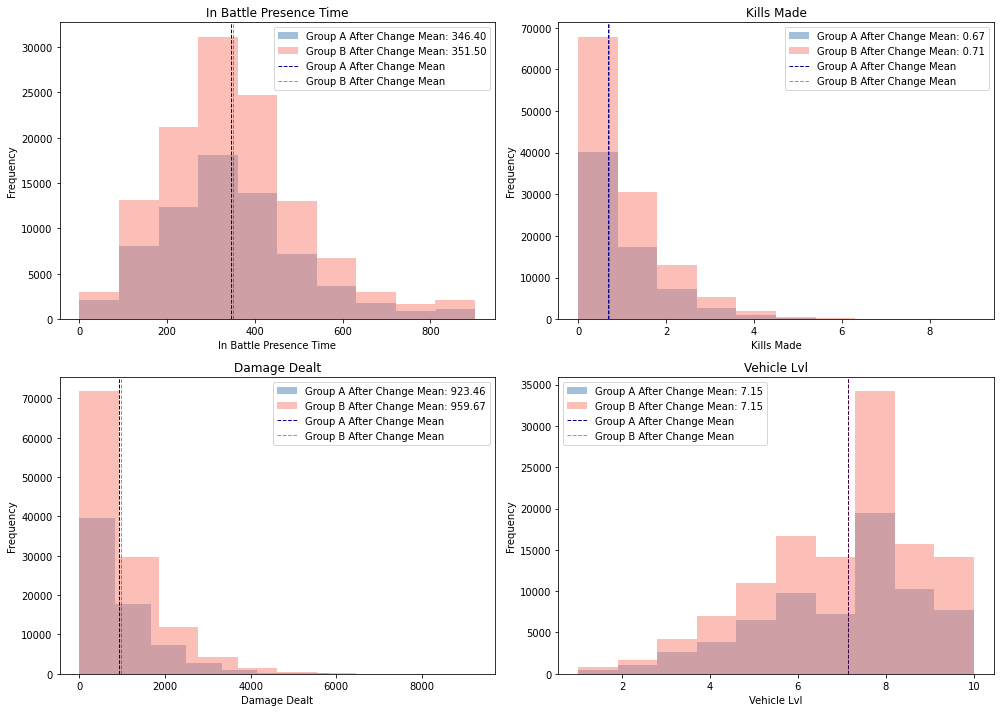

In [31]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# List of metrics to compare
metrics = ['in_battle_presence_time', 'kills_made', 'damage_dealt', 'vehicle_lvl']

# Plot histograms to compare two periods
plot_histograms_comparison(
    group_A_change_period, 
    group_B_change_period, 
    'Group A After Change', 
    'Group B After Change', 
    metrics, 
    axes
)

plt.tight_layout()
plt.show()

In [32]:
# Perform tests and print results
def perform_tests(group1, group2, feature):
    # Calculate mean values
    mean_group1 = group1[feature].mean()
    mean_group2 = group2[feature].mean()
    
    # Print means
    print(f"Mean {feature} for Group 1: {mean_group1}")
    print(f"Mean {feature} for Group 2: {mean_group2}")
    
    # Perform t-test
    t_stat, p_value = ttest_ind(group1[feature].dropna(), group2[feature].dropna())
    print(f"T-test result for {feature}: t-statistic = {t_stat}, p-value = {p_value}")
    
    # Perform Mann-Whitney U test (non-parametric)
    u_stat, u_p_value = mannwhitneyu(group1[feature].dropna(), group2[feature].dropna())
    print(f"Mann-Whitney U test result for {feature}: U-statistic = {u_stat}, p-value = {u_p_value}")
    
    # Explain results
    if p_value < 0.05:
        print(f"The difference in {feature} between the two groups is statistically significant (p < 0.05).")
    else:
        print(f"The difference in {feature} between the two groups is not statistically significant (p >= 0.05).")
    
    print()


In [33]:
# Create plots
def plot_comparison(group1, group2, feature, title):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(group1[feature], bins=30, color='blue', label='Group 1', alpha=0.5)
    sns.histplot(group2[feature], bins=30, color='red', label='Group 2', alpha=0.5)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.boxplot(data=[group1[feature], group2[feature]], palette='Set2')
    plt.title(f'Boxplot of {feature}')
    plt.xticks([0, 1], ['Group 1', 'Group 2'])
    plt.ylabel(feature)

    plt.tight_layout()
    plt.show()


**comparasion in group A & B: before change**

Comparison between Group A Before Change and Group B Same Period:
Mean damage_dealt for Group 1: 945.6578330972873
Mean damage_dealt for Group 2: 986.3273442926603
T-test result for damage_dealt: t-statistic = -6.688469002967953, p-value = 2.2668092377009382e-11
Mann-Whitney U test result for damage_dealt: U-statistic = 1173718137.5, p-value = 0.000499323137730636
The difference in damage_dealt between the two groups is statistically significant (p < 0.05).

Mean kills_made for Group 1: 0.685150887896285
Mean kills_made for Group 2: 0.718607702400247
T-test result for kills_made: t-statistic = -5.019542110475415, p-value = 5.188217045004228e-07
Mann-Whitney U test result for kills_made: U-statistic = 1176181222.0, p-value = 0.0010461105003602444
The difference in kills_made between the two groups is statistically significant (p < 0.05).

Mean in_battle_presence_time for Group 1: 348.30417256781783
Mean in_battle_presence_time for Group 2: 353.5088986648144
T-test result for in_battle_p

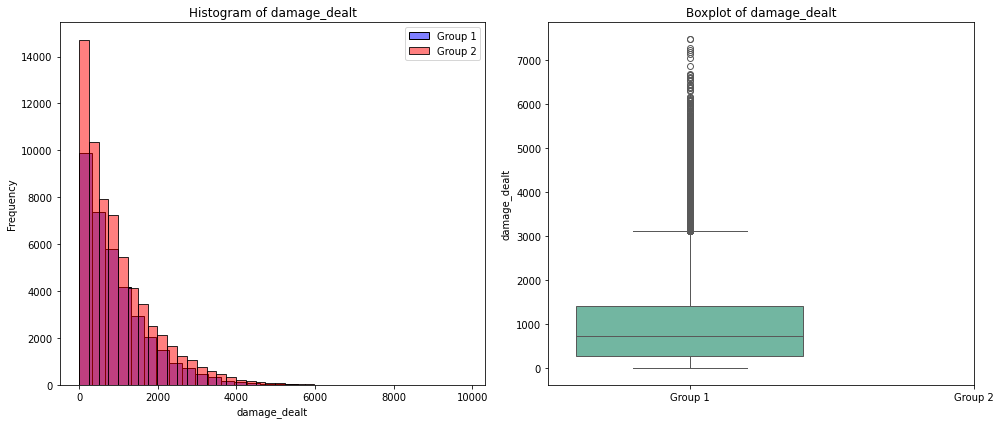

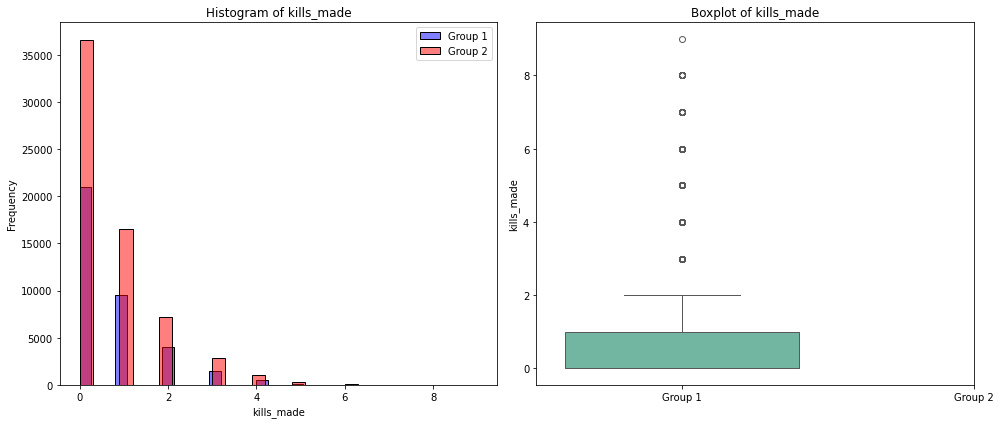

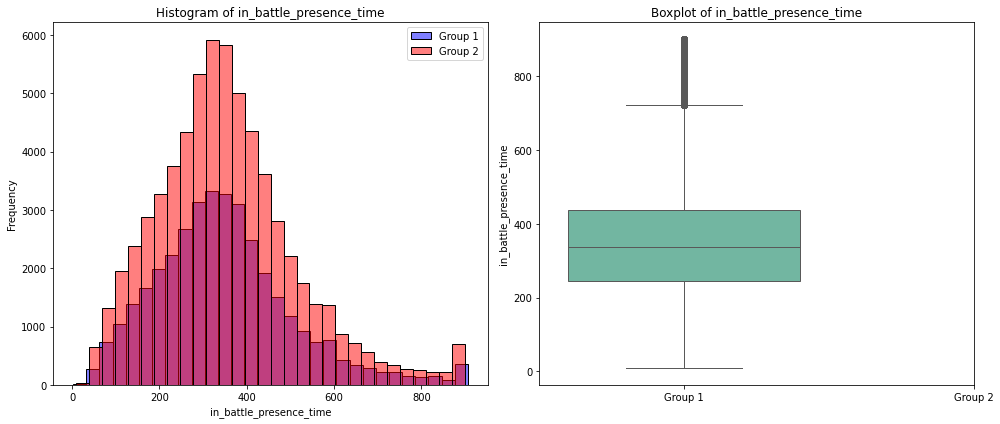

In [34]:
# Compare Group A before change and Group B same period
print("Comparison between Group A Before Change and Group B Same Period:")
perform_tests(group_A_before_change, group_B_same_period, 'damage_dealt')
perform_tests(group_A_before_change, group_B_same_period, 'kills_made')
perform_tests(group_A_before_change, group_B_same_period, 'in_battle_presence_time')

print("----------------------------------------------------------------------------------------------------------")

plot_comparison(group_A_before_change, group_B_same_period, 'damage_dealt', 'Damage Dealt Comparison')
plot_comparison(group_A_before_change, group_B_same_period, 'kills_made', 'Kills Made Comparison')
plot_comparison(group_A_before_change, group_B_same_period, 'in_battle_presence_time', 'Presence Time')


**comparasion in group A and B: after change**

Comparison between Group A Before Change and Group B Same Period:
Mean damage_dealt for Group 1: 923.455050234136
Mean damage_dealt for Group 2: 959.6681728584792
T-test result for damage_dealt: t-statistic = -8.277906822762278, p-value = 1.261640756432098e-16
Mann-Whitney U test result for damage_dealt: U-statistic = 4061546995.0, p-value = 2.769649765195309e-09
The difference in damage_dealt between the two groups is statistically significant (p < 0.05).

Mean kills_made for Group 1: 0.6725865143453615
Mean kills_made for Group 2: 0.7125150340772417
T-test result for kills_made: t-statistic = -8.169086159390936, p-value = 3.126274128049365e-16
Mann-Whitney U test result for kills_made: U-statistic = 4052049582.0, p-value = 2.9286543762468066e-14
The difference in kills_made between the two groups is statistically significant (p < 0.05).

Mean in_battle_presence_time for Group 1: 346.40168461951083
Mean in_battle_presence_time for Group 2: 351.4961579580382
T-test result for in_battle

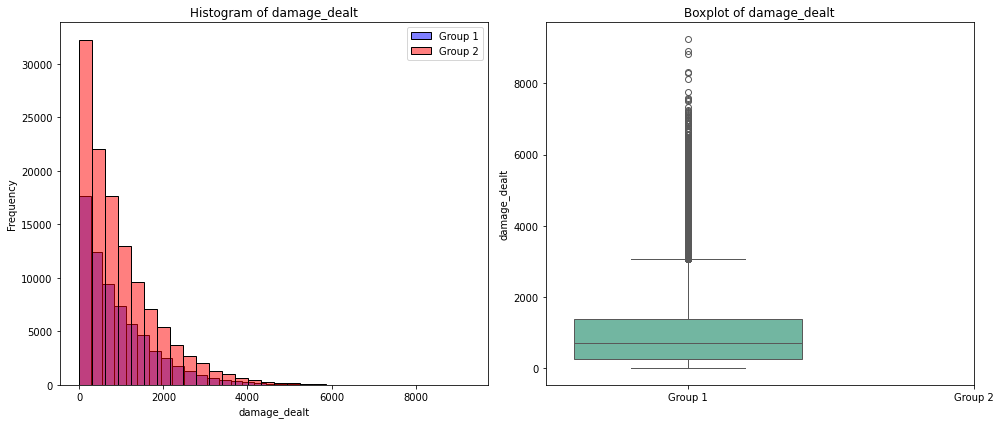

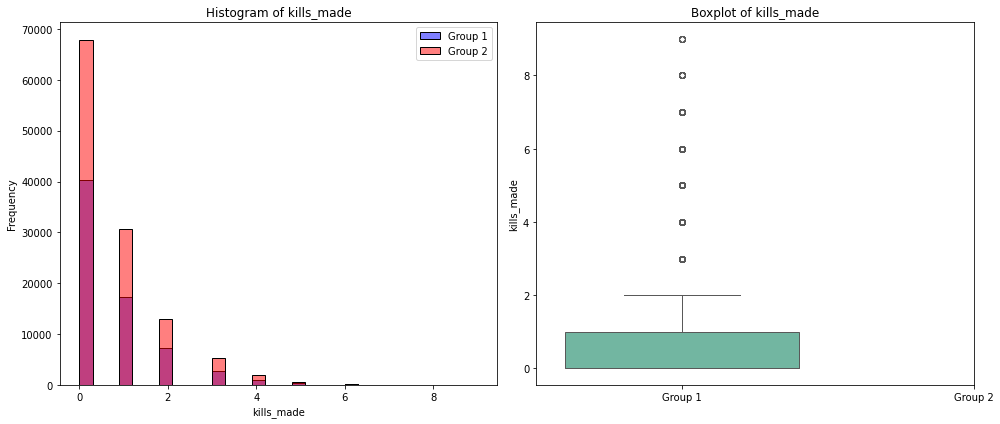

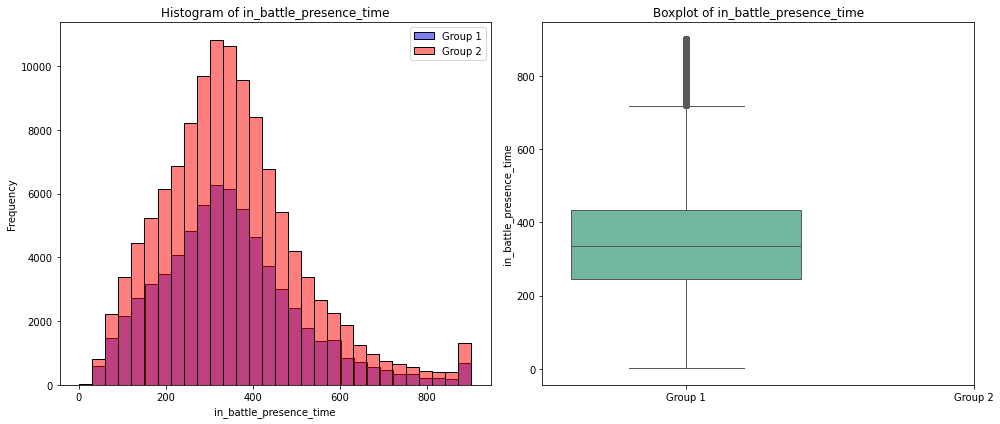

In [35]:
# Compare Group A before change and Group B same period
print("Comparison between Group A Before Change and Group B Same Period:")
perform_tests(group_A_change_period, group_B_change_period, 'damage_dealt')
perform_tests(group_A_change_period, group_B_change_period, 'kills_made')
perform_tests(group_A_change_period, group_B_change_period, 'in_battle_presence_time')

print("----------------------------------------------------------------------------------------------------------")

plot_comparison(group_A_change_period, group_B_change_period, 'damage_dealt', 'Damage Dealt Comparison')
plot_comparison(group_A_change_period, group_B_change_period, 'kills_made', 'Kills Made Comparison')
plot_comparison(group_A_change_period, group_B_change_period, 'in_battle_presence_time', 'Presence Time')


**comparasion in group A & A: before and after change**

Comparison between Group A Before Change and Group B Same Period:
Mean damage_dealt for Group 1: 945.6578330972873
Mean damage_dealt for Group 2: 923.455050234136
T-test result for damage_dealt: t-statistic = 3.8531431232087283, p-value = 0.00011668000814403159
Mann-Whitney U test result for damage_dealt: U-statistic = 1289904640.0, p-value = 5.562670832102179e-07
The difference in damage_dealt between the two groups is statistically significant (p < 0.05).

Mean kills_made for Group 1: 0.685150887896285
Mean kills_made for Group 2: 0.6725865143453615
T-test result for kills_made: t-statistic = 1.954176936635808, p-value = 0.050682929172818116
Mann-Whitney U test result for kills_made: U-statistic = 1280020243.0, p-value = 0.001046795133871114
The difference in kills_made between the two groups is not statistically significant (p >= 0.05).

Mean in_battle_presence_time for Group 1: 348.30417256781783
Mean in_battle_presence_time for Group 2: 346.40168461951083
T-test result for in_batt

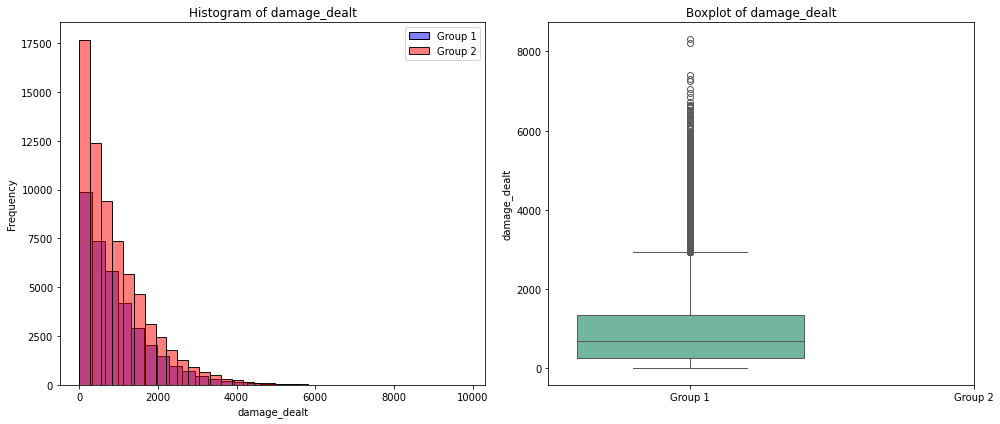

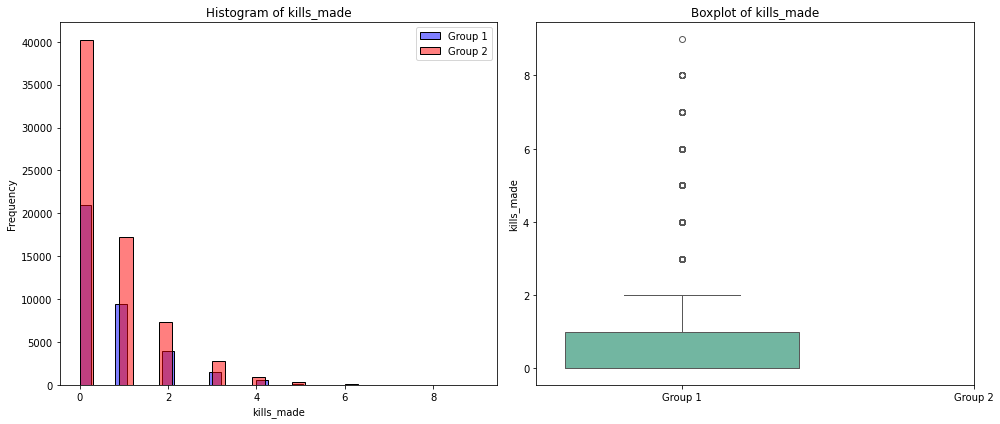

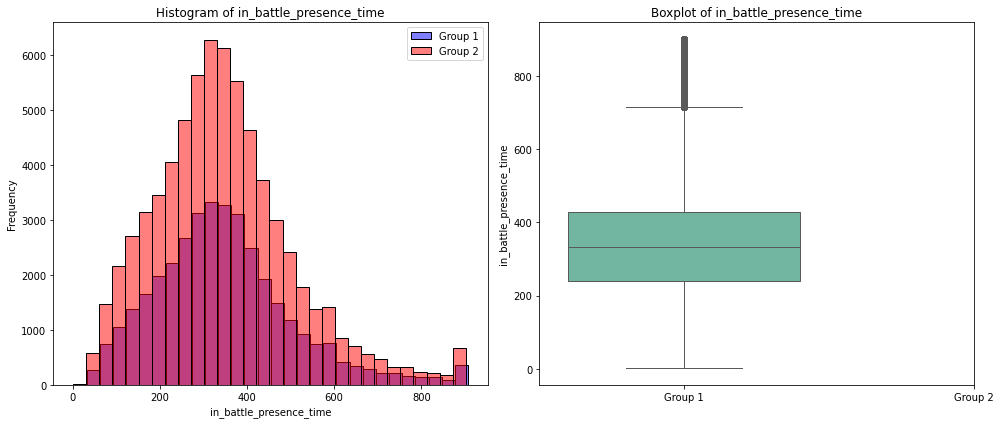

In [36]:
# Compare Group A before change and Group B same period
print("Comparison between Group A Before Change and Group B Same Period:")
perform_tests(group_A_before_change, group_A_change_period, 'damage_dealt')
perform_tests(group_A_before_change, group_A_change_period, 'kills_made')
perform_tests(group_A_before_change, group_A_change_period, 'in_battle_presence_time')

print("----------------------------------------------------------------------------------------------------------")

plot_comparison(group_A_before_change, group_A_change_period, 'damage_dealt', 'Damage Dealt Comparison')
plot_comparison(group_A_before_change, group_A_change_period, 'kills_made', 'Kills Made Comparison')
plot_comparison(group_A_before_change, group_A_change_period, 'in_battle_presence_time', 'Presence Time')

**Overall Metric Comparison. Outcomes**:

1. Cohort B consistently shows higher metrics compared to Cohort A both before and after the change. This suggests that, overall, Cohort B has better performance or higher values in the metrics analyzed.
Change Period Comparison:

2. During the change period, metrics for Cohort A decreased relative to Cohort B. This indicates a decline in performance or values for Cohort A, while Cohort B maintained or improved its metrics during the same period.

**Comparison of Cohort A Before and After Change**

1. Metrics Analysis:
- damage_dealt: The metric for damage_dealt in Cohort A showed a significant decrease after the change. This suggests that players in Cohort A experienced a notable drop in their damage-dealing capability post-change.
- kills_made: The number of kills made by players in Cohort A did not show a statistically significant change before and after the change. This indicates that the change did not impact the kill rate significantly.
- in_battle_presence_time: The time spent in battle by players in Cohort A did not show a significant change before and after the change. This suggests that the change did not affect the amount of time players spent in battles significantly.

**Summary**
1. Cohort B consistently outperformed Cohort A in various metrics, both before and after a change.
During the period of change, Cohort A experienced a decline in its metrics, contrasting with Cohort B, which either maintained or improved its performance.
2. Within Cohort A, the damage_dealt metric significantly decreased after the change, while kills_made and in_battle_presence_time did not show significant differences, indicating a specific impact on damage-related performance.

## Task 3.2
- In the attached data_2.csv file, there are data on the number of active players during the period of 2016–2017, where: day_id, dau
- Make a forecast on the DAU index for the period of 3 months of 2018 (January–March). Please specify the method and approach used to build the predicted values.

In [37]:
dau_df = pd.read_csv('data_2.csv')
dau_df.head()

,DAY_ID,DAU
0,03/01/16,646456
1,01/01/16,595094
2,19/01/16,529205
3,14/01/16,533003
4,22/01/16,548823


In [38]:
dau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DAY_ID  731 non-null    object
 1   DAU     731 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.5+ KB


In [50]:
dau_df.columns = ['dt', 'dau']
dau_df['dt'] = pd.to_datetime(dau_df['dt'])
dau_df = dau_df.sort_values(by = 'dt').reset_index()[['dt', 'dau']]

In [40]:
dau_df[dau_df.duplicated()]

,dt,dau


In [41]:
dau_df.head()

,dt,dau
0,2016-01-01,595094
1,2016-01-02,538126
2,2016-01-03,496931
3,2016-01-04,552736
4,2016-01-05,539404


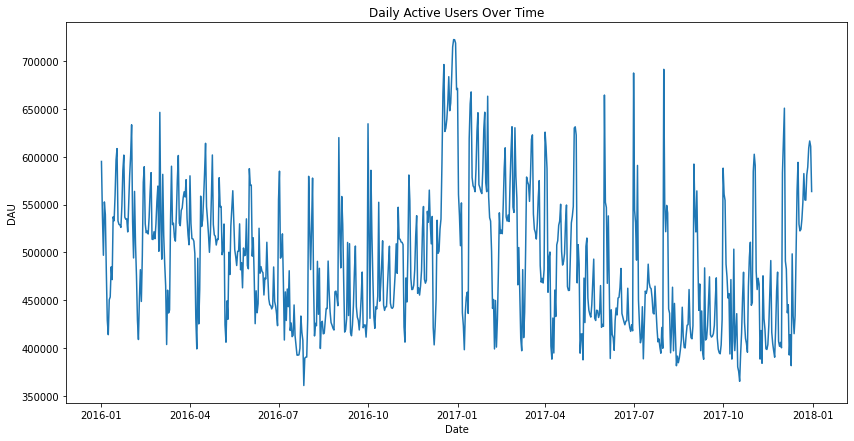

ADF Statistic: -4.944333
p-value: 0.000029
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


In [42]:
# Check the data for stationarity

# Plot the daily active users
plt.figure(figsize=(14, 7))
plt.plot(dau_df['dt'], dau_df['dau'])
plt.title('Daily Active Users Over Time')
plt.xlabel('Date')
plt.ylabel('DAU')
plt.show()

# Perform the Dickey-Fuller test for stationarity
result = adfuller(dau_df['dau'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


In [49]:
# Split the data into training and test sets
train_df = pd.concat([
    dau_df[dau_df['dt'].dt.year == 2016],
    dau_df[(dau_df['dt'].dt.year == 2017) & (dau_df['dt'].dt.quarter < 4)]
])

test_df = dau_df[(dau_df['dt'].dt.year == 2017) & (dau_df['dt'].dt.quarter == 4)]

# Prepare the data for the model
train_df['day_of_year'] = train_df['dt'].dt.dayofyear
test_df['day_of_year'] = test_df['dt'].dt.dayofyear

X_train = train_df[['day_of_year']]
y_train = train_df['dau']
X_test = test_df[['day_of_year']]
y_test = test_df['dau']

# Create and train the Random Forest Regressor model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Predict on the test period (Q4 2017)
y_pred = model_rf.predict(X_test)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 66562.69
RMSE: 77482.79


/var/folders/1w/fxwbqyv52h5bq4v1v80dmd4w0000gn/T/ipykernel_6134/2064950115.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['day_of_year'] = test_df['dt'].dt.dayofyear


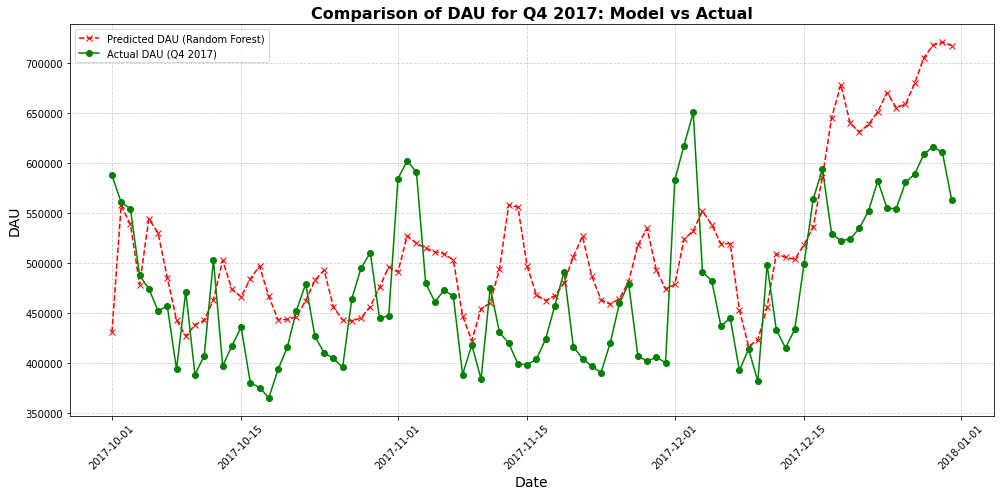

In [44]:
# Visualization for Q4 2017
plt.figure(figsize=(14, 7))

# Predicted data (Q4 2017)
plt.plot(test_df['dt'], y_pred, label='Predicted DAU (Random Forest)', color='red', linestyle='--', marker='x')

# Actual data (Q4 2017)
plt.plot(test_df['dt'], y_test, label='Actual DAU (Q4 2017)', color='green', linestyle='-', marker='o')

# Add additional plot elements
plt.title('Comparison of DAU for Q4 2017: Model vs Actual', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('DAU', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

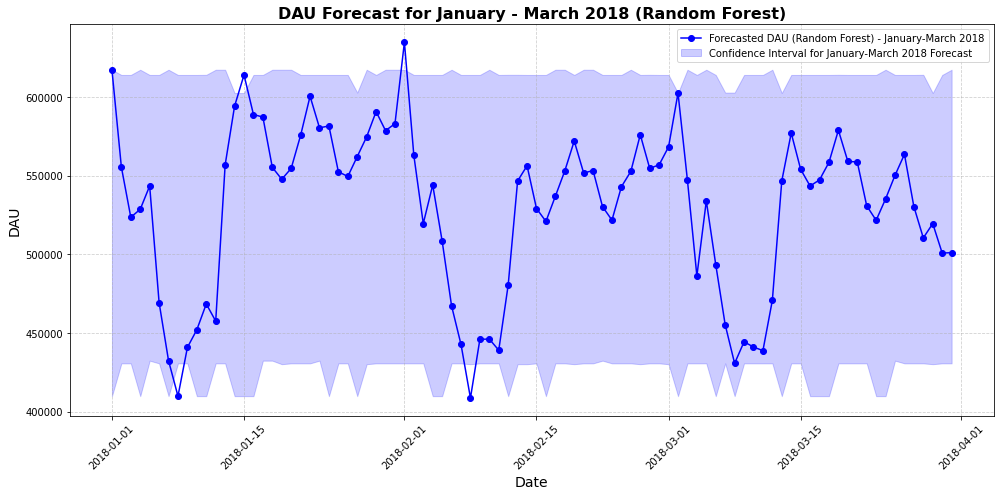

In [45]:
# Forecasting for January - March 2018
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2018-03-31')
forecast_dates = pd.date_range(start=start_date, end=end_date, freq='D')

forecast_df = pd.DataFrame({'ds': forecast_dates})
forecast_df['day_of_year'] = forecast_df['ds'].dt.dayofyear

# Forecasting for January - March 2018
forecast_df['yhat'] = model_rf.predict(forecast_df[['day_of_year']])

# To estimate confidence intervals, we use bootstrapping
def get_bootstrap_intervals(X, model, n_bootstraps=1000):
    bootstrapped_preds = []
    for _ in range(n_bootstraps):
        indices = np.random.choice(len(X), len(X), replace=True)
        X_boot = X.iloc[indices]
        y_boot = model.predict(X_boot)
        bootstrapped_preds.append(y_boot)
    bootstrapped_preds = np.array(bootstrapped_preds)
    lower_bound = np.percentile(bootstrapped_preds, 2.5, axis=0)
    upper_bound = np.percentile(bootstrapped_preds, 97.5, axis=0)
    return lower_bound, upper_bound

# Getting confidence intervals
X_forecast = forecast_df[['day_of_year']]
lower_bound, upper_bound = get_bootstrap_intervals(X_forecast, model_rf)

# Visualization of the forecast for January - March 2018
plt.figure(figsize=(14, 7))

# Forecasted data for January - March 2018
plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Forecasted DAU (Random Forest) - January-March 2018', color='blue', linestyle='-', marker='o')

# Confidence interval
plt.fill_between(forecast_df['ds'], lower_bound, upper_bound, color='blue', alpha=0.2, label='Confidence Interval for January-March 2018 Forecast')

# Adding additional plot elements
plt.title('DAU Forecast for January - March 2018 (Random Forest)', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('DAU', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [46]:
# metrics for projected period
print(f'Mean value is {forecast_df["yhat"].mean()}')
print(f'Median value is {forecast_df["yhat"].median()}')

Mean value is 529746.4247575836
Median value is 546638.4151071429


### **Method: Random Forest Regressor**

**1. Random Forest Regressor Overview:**
- **Ensemble Method:** The Random Forest Regressor is an ensemble learning method that builds predictions by combining multiple decision trees. Each tree is trained on a different random subset of the data and features.
- **Aggregation:** The predictions from all decision trees are averaged to produce the final output. This averaging process enhances the model's accuracy and stability compared to using a single decision tree.

**2. Preprocessing:**
- **Check for Stationarity:** Before applying the model, it is crucial to ensure that the data is stationary. This involves examining the time series for trends or seasonality. A plot of daily active users (DAU) over time is generated to visually inspect for any trends. Additionally, the Augmented Dickey-Fuller (ADF) test is conducted to statistically test for stationarity. If the data is found to be non-stationary, appropriate transformations or differencing techniques are applied to make it stationary.

**3. Data Preparation:**
- **Split Data:** The dataset is divided into training and testing subsets. The training set comprises data from 2016 and the first three quarters of 2017, while the test set includes data from the fourth quarter of 2017.
- **Feature Engineering:** For both the training and testing datasets, the 'day of the year' is extracted from the date field and used as the input feature for the model.

**4. Model Training:**
- **Initialize Model:** The Random Forest Regressor is configured with 100 decision trees and a fixed random state to ensure consistent results. This setup allows the model to benefit from the collective predictions of multiple trees.
- **Train Model:** The model is trained using 'day of the year' as the feature and DAU (Daily Active Users) as the target variable, fitting the model to historical data.

**5. Forecasting:**
- **Predict Test Set:** The trained model is applied to the test set (fourth quarter of 2017) to make predictions. This step evaluates the model's performance on unseen data.
- **Forecast Future Data:** The model is also used to forecast DAU values for the period from January to March 2018, predicting future values based on the 'day of the year.'

**6. Confidence Intervals:**
- **Estimate Intervals:** Confidence intervals for the forecasts are determined using bootstrapping. This involves generating multiple bootstrap samples from the forecast data, making predictions for each sample, and calculating the percentiles to establish a range where the true forecast values are expected to lie.

# Thank you for your attention. I look forward to discussing the findings and any questions you may have.